In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm 

from sklearn.neighbors import KernelDensity
import joblib
from sklearn.metrics import roc_auc_score
import os
import random
import xgboost
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.preprocessing import StandardScaler

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier
import category_encoders as ce



Bad key "text.kerning_factor" on line 4 in
/opt/anaconda3/envs/bigdatalab_cpu_202101/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
InputAOI=pd.read_csv('data-challenge-phme/data/AOI_training.csv.zip')
InputAOI['PinNumber']=InputAOI['PinNumber'].astype('Int64').astype(str)
InputAOI['FigureID2']=InputAOI['FigureID']
InputAOI['ComponentID2']=InputAOI['ComponentID']
InputAOI['Count_Pin']=InputAOI.groupby(["PanelID","FigureID2","ComponentID2"])["PinNumber"].transform('count')
InputAOI['Count_Pin_Figure']=InputAOI.groupby(["PanelID","FigureID2"])["PinNumber"].transform('count')
InputAOI['Count_Pin_Panel']=InputAOI.groupby(["PanelID"])["PinNumber"].transform('count')


InputAOI['Target']=InputAOI['OperatorLabel'].astype('category').cat.codes

InputSPI=pd.DataFrame()
for item in range(4):
    InputSPI=pd.concat([InputSPI,pd.read_csv('data-challenge-phme/data/SPI_training_'+str(item)+'.csv.zip')])
InputAOI['key_spi']=(InputAOI['PanelID'].astype(str)+'_'+InputAOI['FigureID'].astype(str)+'_'+InputAOI['ComponentID'].astype(str))

InputSPI['FigureID2']=InputSPI['FigureID']
InputSPI['ComponentID2']=InputSPI['ComponentID']
InputSPI['key_spi']=(InputSPI['PanelID'].astype(str)+'_'+InputSPI['FigureID'].astype(int,errors='ignore').astype(str)+'_'+InputSPI['ComponentID'].astype(str))
Features_to_bin=['Volume(%)',  'Area(%)', 'OffsetX(%)','OffsetY(%)',]


/opt/anaconda3/envs/bigdatalab_cpu_202101/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3156: DtypeWarning: Columns (17) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
InputAOI['PanelID_FigureID_ComponentID']=InputAOI['PanelID'].astype(str)+'_'+InputAOI['FigureID'].astype(str)+'_'+InputAOI['ComponentID'].astype(str)


In [4]:
listAOI_Label=InputAOI.AOILabel.unique().tolist()
joblib.dump(listAOI_Label,'listAOI_Label')

['listAOI_Label']

In [5]:
listAOI_Label=InputAOI.AOILabel.unique().tolist()
for element in listAOI_Label:
    InputAOI.loc[:,element]=0

In [6]:
for item in InputAOI['PanelID_FigureID_ComponentID'].unique().tolist():
    list_item_aoilabel=[]
    df_inter=InputAOI.loc[InputAOI['PanelID_FigureID_ComponentID']==item]
    list_item_aoilabel=df_inter.AOILabel.unique()
    for element in listAOI_Label:
        if element in list_item_aoilabel:
            InputAOI.loc[InputAOI['PanelID_FigureID_ComponentID']==item,element]=1
InputSPI=InputSPI.dropna(subset=['FigureID'])


In [7]:
aoi_outter=InputAOI.copy()
aoi_outter['FigureID_ComponentID']=(aoi_outter['FigureID'].astype(str)+'_'+aoi_outter['ComponentID'].astype(str)).astype("category").cat.codes
    

In [8]:
aoi_outter=aoi_outter.loc[~aoi_outter.RepairLabel.isna()]
aoi_outter=aoi_outter.loc[~(aoi_outter.RepairLabel=='NotYetClassified')]

In [9]:

Num_features=['Shape(um)',
   'PosX(mm)', 'PosY(mm)','SizeX', 'SizeY']

In [10]:
InputSPI['Shape(um)']=pd.to_numeric(InputSPI['Shape(um)'])

In [11]:
InputSPI=InputSPI.loc[InputSPI['key_spi'].isin(aoi_outter['key_spi'].unique().tolist())]

In [12]:
InputSPI_grouped=InputSPI.groupby(["PanelID","FigureID2","ComponentID2"])[Features_to_bin+Num_features].mean().reset_index()

In [13]:
aoi_outter=aoi_outter.merge(InputSPI_grouped,how="left",left_on=["PanelID","FigureID2","ComponentID2"],right_on=["PanelID","FigureID2","ComponentID2"])

In [14]:
aoi_outter=aoi_outter.drop_duplicates(subset=["PanelID","FigureID2","ComponentID2"])

In [15]:
aoi_outter.columns

Index(['PanelID', 'FigureID', 'MachineID', 'ComponentID', 'PinNumber',
       'AOILabel', 'OperatorLabel', 'RepairLabel', 'FigureID2', 'ComponentID2',
       'Count_Pin', 'Count_Pin_Figure', 'Count_Pin_Panel', 'Target', 'key_spi',
       'PanelID_FigureID_ComponentID', 'Coplanarity', 'Translated', 'Soldered',
       'UnSoldered', 'Size', 'LeanSoldering', 'Misaligned', 'Missing',
       'Jumper', 'Polarity', 'Broken', 'FigureID_ComponentID', 'Volume(%)',
       'Area(%)', 'OffsetX(%)', 'OffsetY(%)', 'Shape(um)', 'PosX(mm)',
       'PosY(mm)', 'SizeX', 'SizeY'],
      dtype='object')

In [16]:
Features_to_bin=['Volume(%)',  'Area(%)', 'OffsetX(%)','OffsetY(%)']

In [17]:
aoi_outter.columns

Index(['PanelID', 'FigureID', 'MachineID', 'ComponentID', 'PinNumber',
       'AOILabel', 'OperatorLabel', 'RepairLabel', 'FigureID2', 'ComponentID2',
       'Count_Pin', 'Count_Pin_Figure', 'Count_Pin_Panel', 'Target', 'key_spi',
       'PanelID_FigureID_ComponentID', 'Coplanarity', 'Translated', 'Soldered',
       'UnSoldered', 'Size', 'LeanSoldering', 'Misaligned', 'Missing',
       'Jumper', 'Polarity', 'Broken', 'FigureID_ComponentID', 'Volume(%)',
       'Area(%)', 'OffsetX(%)', 'OffsetY(%)', 'Shape(um)', 'PosX(mm)',
       'PosY(mm)', 'SizeX', 'SizeY'],
      dtype='object')

In [18]:
list_var_to_encode=["ComponentID","FigureID_ComponentID"]#+Features_alpha


for var in list_var_to_encode:
    aoi_outter[var]=aoi_outter[var].astype('category').cat.codes
    
aoi_outter["MachineID"]=aoi_outter["MachineID"].astype('category').cat.codes

    

In [20]:
InputAOI

,PanelID,FigureID,MachineID,ComponentID,PinNumber,AOILabel,OperatorLabel,RepairLabel,FigureID2,ComponentID2,...,Translated,Soldered,UnSoldered,Size,LeanSoldering,Misaligned,Missing,Jumper,Polarity,Broken
0,26319044800520102844,2,A,C31,<NA>,Coplanarity,Good,NaN,2,C31,...,0,0,0,0,0,0,0,0,0,0
1,26319044800520102844,2,A,D1,1,Translated,Good,NaN,2,D1,...,1,1,0,0,0,0,0,0,0,0
2,26319044800520102844,2,A,D1,1,Soldered,Good,NaN,2,D1,...,1,1,0,0,0,0,0,0,0,0
3,26319044900520102844,6,B,BC1,2,UnSoldered,Good,NaN,6,BC1,...,0,0,1,0,0,0,0,0,0,0
4,26319044900520102844,7,B,BC1,2,UnSoldered,Good,NaN,7,BC1,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31612,27219026400520102844,3,B,BC1,2,UnSoldered,Good,NaN,3,BC1,...,0,0,1,0,0,0,0,0,0,0
31613,27219026400520102844,4,B,BC1,2,UnSoldered,Good,NaN,4,BC1,...,0,0,1,0,0,0,0,0,0,0
31614,27219026400520102844,5,B,BC1,2,UnSoldered,Good,NaN,5,BC1,...,0,0,1,0,0,0,0,0,0,0
31615,27219026400520102844,7,B,BC1,2,UnSoldered,Good,NaN,7,BC1,...,0,0,1,0,0,0,0,0,0,0


In [21]:
aoi_outter['Target']=aoi_outter['RepairLabel'].astype('category').cat.codes
 

In [22]:
def frequency_encoding(column, df, df_test=None):
    frequencies = df[column].value_counts().reset_index()
    df_values = df[[column]].merge(frequencies, how='left', 
                                   left_on=column, right_on='index').iloc[:,-1].values
    if df_test is not None:
        df_test_values = df_test[[column]].merge(frequencies, how='left', 
                                                 left_on=column, right_on='index').fillna(1).iloc[:,-1].values
    else:
        df_test_values = None
    return df_values, df_test_values

In [23]:
list_panel_id=InputAOI.PanelID.unique().tolist()


def cross_validation_panel_id_creation(list_panel_id,n_fold=5):
    Fold_list=[]
    random.shuffle(list_panel_id)
    list_panel_id=joblib.load("list_panel_id")
    len_fold=(len(list_panel_id))//n_fold
    for fold in range(n_fold):
        Fold_list.append(list_panel_id[fold*len_fold:(fold+1)*len_fold])
    return(Fold_list)
Fold_list=cross_validation_panel_id_creation(list_panel_id)
#Final_df=Final_df.loc[Final_df['ComponentID2']!="BC1"]
f1_score_list=[]
list_confusion_matrix=[]
for Test_fold_indice in range(5):
    print(Test_fold_indice)
    Train_indice=[]
    count_indice_fit_pin_training=0
    for indices in range(len(Fold_list)):
        if indices!=Test_fold_indice:
            Train_indice=Train_indice+Fold_list[indices]
        else:
            Test_indices=Fold_list[indices]
            Train_indice=Train_indice+Fold_list[indices]

    Train_df=aoi_outter.loc[aoi_outter["PanelID"].isin(Train_indice)].reset_index(drop=True)
    Test_df=aoi_outter.loc[aoi_outter["PanelID"].isin(Test_indices)].reset_index(drop=True)
    X_train=Train_df
    X_val=Test_df
    y_train=Train_df['Target']
    y_val=Test_df['Target']
    y_train=Train_df['Target']
    y_train=Train_df['Target']
    y_val=Test_df['Target']
    
    
    encoder=ce.CatBoostEncoder()

    AE_train=encoder.fit_transform(X_train[list_var_to_encode].copy(),y_train)
    AE_train.columns=[x+"_encoded" for x in AE_train.columns.tolist()]
    X_train_final=pd.concat([X_train,AE_train],axis=1)
    joblib.dump(encoder,"Cat_boost_step3_no_fusion")

    AE_val=encoder.transform(X_val[list_var_to_encode].copy())
    AE_val.columns=[x+"_encoded" for x in AE_val.columns.tolist()]
    X_val_final=pd.concat([X_val,AE_val],axis=1)
    #col_features=[x for x in X_train_final.columns.tolist() if "_encoded" in str(x)]#+[x for x in X_train_final.columns.tolist() if "_is_in_panel" in str(x)]
    #col_features=col_features#+[x for x in X_train_final.columns.tolist() if '_is_in_figure' in str(x)]
    col_features=Num_features+[x+"_encoded" for x in list_var_to_encode]+["Count_Pin","Count_Pin_Figure","Count_Pin_Panel"]+listAOI_Label+Features_to_bin+["MachineID"]#+[x for x in X_val_final.columns.tolist() if "_counts" in x]#
    X_train_final=X_train_final.replace(np.nan,0)
    X_val_final=X_val_final.replace(np.nan,0)
    X_train_final=X_train_final[col_features].to_numpy()
    X_val_final=X_val_final[col_features].to_numpy()

    ratio=np.sum(y_train==0)/np.sum(y_train==1)
    


    xgb_cl = xgboost.XGBClassifier(objective="binary:logistic",n_estimators =200,max_depth = 15,scale_pos_weight=ratio)
    #xgb_cl = xgboost.XGBClassifier(**Best_trial)
    xgb_cl.fit(X_train_final, y_train)
    joblib.dump(xgb_cl,"xgboost_step3_outter")

    res_train=xgb_cl.predict(X_train_final)
    res_test=xgb_cl.predict(X_val_final)

    X_train['Pred']=res_train
    X_val['Pred']=res_test
   
    
    y_train=X_train.groupby(["PanelID","FigureID","ComponentID"])['Target'].min()
    y_val=X_val.groupby(["PanelID","FigureID","ComponentID"])['Target'].min()


    res_train=X_train.groupby(["PanelID","FigureID","ComponentID"])['Pred'].min()
    res_test=X_val.groupby(["PanelID","FigureID","ComponentID"])['Pred'].min()




    print(confusion_matrix(y_train, res_train,labels=[0,1]))
    print(confusion_matrix(y_val,res_test,labels=[0,1]))

    print(f1_score(y_train, res_train,pos_label=0))
    print(f1_score(y_val, res_test,pos_label=0))

    f1_score_list.append(f1_score(y_val, res_test,pos_label=0))

0
[[120   0]
 [  0 225]]
[[ 7  0]
 [ 0 43]]
1.0
1.0
1
[[120   0]
 [  0 225]]
[[17  0]
 [ 0 32]]
1.0
1.0
2
[[120   0]
 [  0 225]]
[[22  0]
 [ 0 55]]
1.0
1.0
3
[[120   0]
 [  0 225]]
[[54  0]
 [ 0 56]]
1.0
1.0
4
[[120   0]
 [  0 225]]
[[20  0]
 [ 0 39]]
1.0
1.0


In [24]:
    joblib.dump(encoder,"Cat_boost_step3_no_fusion")


['Cat_boost_step3_no_fusion']

In [25]:
np.mean(f1_score_list)

1.0

In [26]:
Num_features

['Shape(um)', 'PosX(mm)', 'PosY(mm)', 'SizeX', 'SizeY']

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm 

from sklearn.neighbors import KernelDensity
import joblib
from sklearn.metrics import roc_auc_score
import os
import random
import xgboost
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.preprocessing import StandardScaler

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import make_scorer
import category_encoders as ce
import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler
import logging
from sklearn.model_selection import cross_val_score

In [28]:



def objective(trial: Trial,X,y) -> float:
    
    joblib.dump(study, 'study.pkl')

    param = {
        'objective': trial.suggest_categorical('objective',['binary:logistic']), 
        'tree_method': trial.suggest_categorical('tree_method',['exact']),  # 'gpu_hist','hist'
        'lambda': trial.suggest_loguniform('lambda',1e-3,10.0),
        'alpha': trial.suggest_loguniform('alpha',1e-3,10.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.3,1.0),
        #'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001,0.1),
        'n_estimators': trial.suggest_categorical('n_estimators', [30,40,50,70,100,150,200]),
        'max_depth': trial.suggest_categorical('max_depth', [3,5,7,8,9,10,11,13,15,17,20]),
        #'random_state': trial.suggest_categorical('random_state', [24,48,2020]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1,300),
        'nthread' : -1,
        #'feval': trial.suggest_categorical('feval',[f1_eval]),
        'scale_pos_weight' : trial.suggest_categorical('scale_pos_weight', [ratio])
        

    }
    
    
    model = xgboost.XGBClassifier(**param,feval=f1_eval)
    
    return cross_val_score(model, X_train_final, y_train, cv=5,scoring=make_scorer(f1_score, pos_label=0)).mean()

In [29]:
optuna.logging.disable_default_handler()  # Stop showing logs in sys.stderr.
from sklearn.metrics import f1_score
import numpy as np

def f1_eval(y_pred, y_true):
    #y_true = dtrain.get_label()
    err = f1_score(y_true,y_pred,pos_label=0)
    return 'f1_err', err

In [30]:
y_train=Train_df['Target']

In [31]:
study = optuna.create_study(direction='maximize')
#study = optuna.create_study(direction='maximize', storage="sqlite:///xgb_optuna_home_credit.db", study_name="optuna_xgb_output_8")
study.optimize(lambda trial : objective(trial,X_train_final,y_train),n_trials= 10)

np.mean(f1_score_list)

1.0

In [32]:
print(f"Sampler is {study.sampler.__class__.__name__}")


Sampler is TPESampler


In [33]:
Best_trial = study.best_trial.params

In [34]:
Best_trial

{'objective': 'binary:logistic',
 'tree_method': 'exact',
 'lambda': 0.003563244623116407,
 'alpha': 1.2401768953062398,
 'colsample_bytree': 0.9333517817531323,
 'learning_rate': 0.00216514258325159,
 'n_estimators': 40,
 'max_depth': 3,
 'min_child_weight': 17,
 'scale_pos_weight': 0.5333333333333333}

In [35]:
model = xgboost.XGBClassifier(**Best_trial)

In [36]:
model.fit(X_train_final,y_train)
print(confusion_matrix(y_train, model.predict(X_train_final),labels=[0,1]))

cross_val_score(model, X_train_final, y_train, cv=5,scoring=make_scorer(f1_score, pos_label=0)).mean()

[[110  10]
 [ 40 185]]


0.8164696417654523

In [34]:
model = xgboost.XGBClassifier(**Best_trial)
model.fit(X_train_final,y_train)
joblib.dump(model,"xgboost_step3_no_fusion")


['xgboost_step3_no_fusion']

In [38]:
model.get_booster().feature_names = col_features


In [39]:
col_features

['Shape(um)',
 'PosX(mm)',
 'PosY(mm)',
 'SizeX',
 'SizeY',
 'ComponentID_encoded',
 'FigureID_ComponentID_encoded',
 'Count_Pin',
 'Count_Pin_Figure',
 'Count_Pin_Panel',
 'Coplanarity',
 'Translated',
 'Soldered',
 'UnSoldered',
 'Size',
 'LeanSoldering',
 'Misaligned',
 'Missing',
 'Jumper',
 'Polarity',
 'Broken',
 'Volume(%)',
 'Area(%)',
 'OffsetX(%)',
 'OffsetY(%)',
 'MachineID']

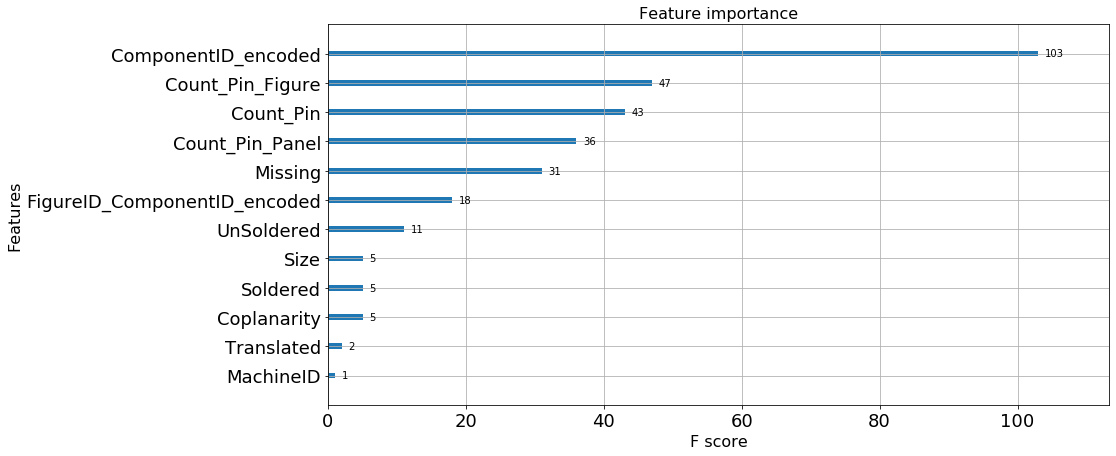

In [41]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (14, 7)
plot_importance(booster=model)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title("Feature importance", fontsize=16)
plt.xlabel("F score", fontsize=16)
plt.ylabel("Features", fontsize=16)
plt.savefig("features_imp_step2_outter3", dpi=200,bbox_inches="tight")

In [52]:
joblib.dump(model,"xgboost_step3_no_fusion")


['xgboost_step3_no_fusion']

In [48]:
X_train_final.shape

(383, 27)

In [73]:
X_val_final=X_val_final[col_features]


/opt/anaconda3/envs/bigdatalab_cpu_202101/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  """Entry point for launching an IPython kernel.


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [85]:
Train_df=aoi_outter.loc[aoi_outter["PanelID"].isin(Train_indice)].reset_index(drop=True)
Test_df=aoi_outter.loc[aoi_outter["PanelID"].isin(Test_indices)].reset_index(drop=True)
X_train=Train_df
X_val=Test_df
y_train=Train_df['Target']
y_val=Test_df['Target']
y_train=Train_df['Target']
y_train=Train_df['Target']
y_val=Test_df['Target']

for column in list_var_to_encode:
    train_values, test_values = frequency_encoding(column, X_train, X_val)
    X_train[column+'_counts'] = train_values
    X_val[column+'_counts'] = test_values

encoder=ce.CatBoostEncoder()

AE_train=encoder.fit_transform(X_train[list_var_to_encode].copy(),y_train)
AE_train.columns=[x+"_encoded" for x in AE_train.columns.tolist()]
X_train_final=pd.concat([X_train,AE_train],axis=1)
joblib.dump(encoder,"Cat_boost_step3_outer")

AE_val=encoder.transform(X_val[list_var_to_encode].copy())
AE_val.columns=[x+"_encoded" for x in AE_val.columns.tolist()]
X_val_final=pd.concat([X_val,AE_val],axis=1)
#col_features=[x for x in X_train_final.columns.tolist() if "_encoded" in str(x)]#+[x for x in X_train_final.columns.tolist() if "_is_in_panel" in str(x)]
#col_features=col_features#+[x for x in X_train_final.columns.tolist() if '_is_in_figure' in str(x)]
col_features=Num_features+[x+"_encoded" for x in list_var_to_encode]+["Count_Pin","Count_Pin_Figure","Count_Pin_Panel"]#+[x for x in X_val_final.columns.tolist() if "_counts" in x]#
#X_train_final=X_train_final.replace(np.nan,0)
#X_val_final=X_val_final.replace(np.nan,0)


In [40]:
X_val_final.shape

(73, 27)

In [79]:
len(col_features)

27

In [83]:
X_train_final.shape

(383, 29)

In [87]:
X_train_final[col_features].columns

Index(['Shape(um)', 'PosX(mm)', 'PosX(mm)', 'PosY(mm)', 'PosY(mm)', 'SizeX',
       'SizeY', 'AOILabel_encoded', 'ComponentID_encoded',
       'FigureID_ComponentID_encoded', 'Volume(%)0.1sup_encoded',
       'Volume(%)0.1inf_encoded', 'Volume(%)1e-06sup_encoded',
       'Volume(%)1e-06inf_encoded', 'Area(%)0.1sup_encoded',
       'Area(%)0.1inf_encoded', 'Area(%)1e-06sup_encoded',
       'Area(%)1e-06inf_encoded', 'OffsetX(%)0.1sup_encoded',
       'OffsetX(%)0.1inf_encoded', 'OffsetX(%)1e-06sup_encoded',
       'OffsetX(%)1e-06inf_encoded', 'OffsetY(%)0.1sup_encoded',
       'OffsetY(%)0.1inf_encoded', 'OffsetY(%)1e-06sup_encoded',
       'OffsetY(%)1e-06inf_encoded', 'Count_Pin', 'Count_Pin_Figure',
       'Count_Pin_Panel'],
      dtype='object')

In [55]:
aa=InputAOI.groupby(["PanelID","FigureID","ComponentID"])['AOILabel'].unique().reset_index()

AttributeError: 'Series' object has no attribute 'get_dummies'